In [1]:
'''
一、相关理论介绍
1、当采用较深层数的网络进行训练时：
*后层网络需要不断调整适应输入数据分布的变化，导致网络学习速度的降低；
*当在神经网络中采用饱和的激活函数时（例如sigmoid、tanh激活函数），网络的训练过程容易陷入梯度饱和区，梯度会变得很小甚至接近于0，参数的更新会
减慢。

2、Batch Normalization
*在对输入数据经过激活函数的处理前，对每个特征进行normalization，让每个特征都有均值为0，方差为1的分布，让数据位于激活函数的敏感区域；
*引入两个可学习的参数γ和β，让神经网络积极取使用和修改这两个参数


二、相关实验过程见下
'''



'\n一、相关理论介绍\n1、当采用较深层数的网络进行训练时：\n*后层网络需要不断调整适应输入数据分布的变化，导致网络学习速度的降低；\n*当在神经网络中采用饱和的激活函数时（例如sigmoid、tanh激活函数），网络的训练过程容易陷入梯度饱和区，梯度会变得很小甚至接近于0，参数的更新会\n减慢。\n\n2、Batch Normalization\n*在对输入数据经过激活函数的处理前，对每个特征进行normalization，让每个特征都有均值为0，方差为1的分布，让数据位于激活函数的敏感区域；\n*引入两个可学习的参数γ和β，让神经网络积极取使用和修改这两个参数\n\n\n二、相关实验过程见下\n'

<IPython.core.display.Javascript object>


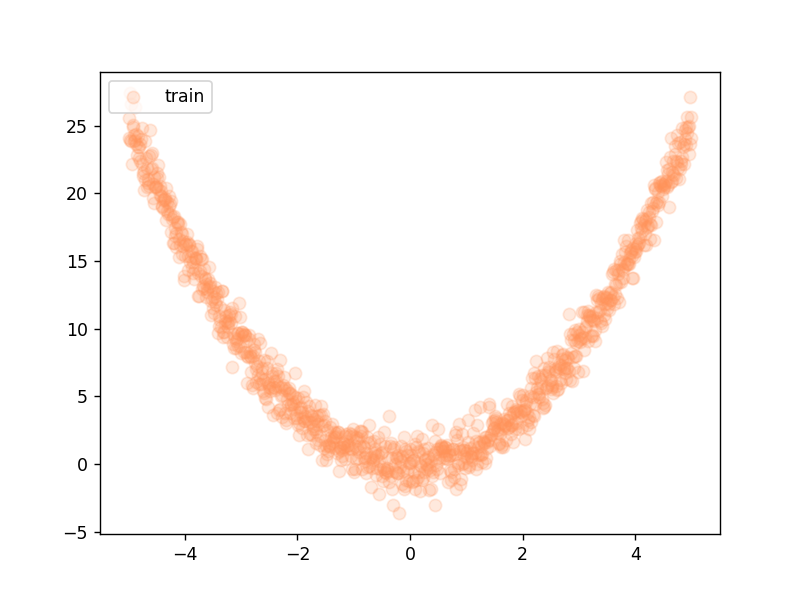

In [2]:
%matplotlib notebook
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np

#定义数据，制造伪数据来模拟一个回归的任务
#train data
x = np.linspace(-5, 5, 1000)[:, np.newaxis]
y = np.square(x) + np.random.normal(0, 1, x.shape)
train_x = torch.from_numpy(x).float()
train_y = torch.from_numpy(y).float()

# test data
test_x = np.linspace(-5, 5, 100)[:, np.newaxis]
test_y = np.square(test_x)  + np.random.normal(0, 1, test_x.shape)
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2,)

# show train data

plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')
plt.show()


In [7]:
#自定义BN层
class MyBN(nn.Module):
    def __init__(self, num_features):
        super(MyBN, self).__init__()
        self.gamma = nn.Parameter(torch.ones((num_features,)),requires_grad=True)   #将γ加入更新的参数列表
        self.beta = nn.Parameter(torch.zeros((num_features,)),requires_grad=True)   #将β加入更新的参数列表
        self.moving_mean = torch.zeros((num_features,))
        self.moving_var = torch.zeros((num_features,))

    def forward(self, x):
        eps=1e-6
        momentum=0.5
        if self.training==False:
            x_ = (x - self.moving_mean) / torch.sqrt(self.moving_var + eps)  
        else:
            xmean = torch.mean(x,dim=0)
            xvar=torch.mean(((x-xmean)**2),dim=0)
            x_ = (x - xmean) / torch.sqrt(xvar + eps) 
            self.moving_mean = momentum * self.moving_mean + (1.0 - momentum) * xmean
            self.moving_var = momentum * self.moving_var + (1.0 - momentum) * xvar
        out = self.gamma * x_ + self.beta  
        return out
    
# 检测自己编写的BN层是否能实现对数据的标准化处理

# 定义一个简单的数据
data=np.array([[1,2],[3,4],[5,6]]).astype(np.float32)
data=torch.from_numpy(data)
print('data: ',data)

#使用自己编写的BN层
mybn=MyBN(num_features=2)
out_mybn=mybn(data)
print('out_mybn: ',out_mybn)

#使用pytorch提供的BN层
bn_pytorch=nn.BatchNorm1d(num_features=2)
out_bn_pytorch=bn_pytorch(data)
print('out_bn_pytorch: ',out_bn_pytorch)

#可以实现对数据的标准化


data:  tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
out_mybn:  tensor([[-1.2247, -1.2247],
        [ 0.0000,  0.0000],
        [ 1.2247,  1.2247]], grad_fn=<AddBackward0>)
out_bn_pytorch:  tensor([[-1.1071, -1.1810],
        [ 0.0000,  0.0000],
        [ 1.1071,  1.1810]], grad_fn=<NativeBatchNormBackward>)


In [8]:
#搭建网络模型，4层神经网络，使用自定义的BN层，使用MSELoss作为损失函数，Adam作为优化器，tanh作为激活函数
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc0=nn.Linear(1,10)
        self.bn0=MyBN(num_features=10)
        self.fc1=nn.Linear(10,10)
        self.bn1=MyBN(num_features=10)
        self.fc2=nn.Linear(10,10)
        self.bn2=MyBN(num_features=10)
        self.fc3=nn.Linear(10,10)
        self.bn3=MyBN(num_features=10)
        self.predict=nn.Linear(10,1)
    
    def forward(self,x):
        x = self.fc0(x)
        x = self.bn0(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc1(x)
        x = self.bn1(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc2(x)
        x = self.bn2(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc3(x)
        x = self.bn3(x)   # batch normalization
        x = torch.tanh(x)

        out=self.predict(x)
        return out

net=Net() 
opt=torch.optim.Adam(net.parameters(),lr=0.02)
#print(opt.param_groups) 
loss_func=nn.MSELoss()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
[134.20645141601562, 115.36129760742188, 67.19647979736328, 34.626895904541016, 24.349117279052734, 17.548583984375, 12.558326721191406, 8.5396728515625, 8.331998825073242, 8.67818546295166]


<IPython.core.display.Javascript object>


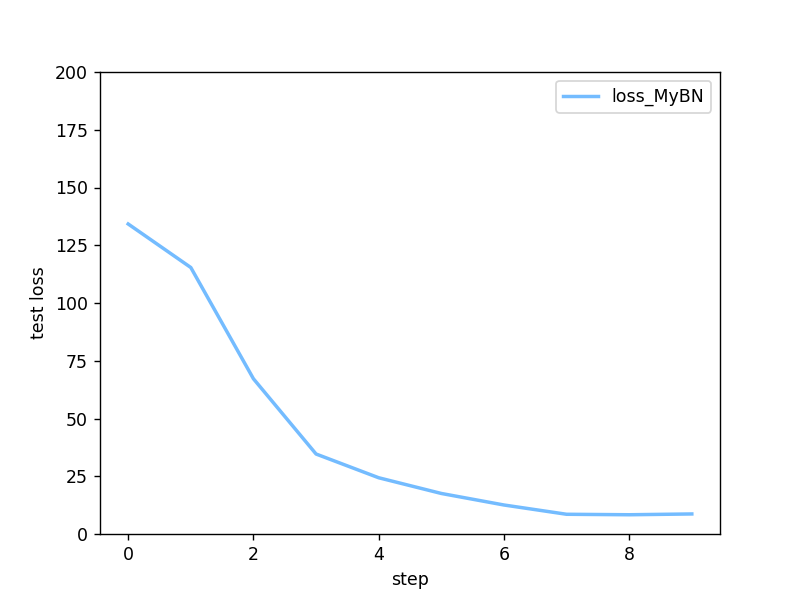

<IPython.core.display.Javascript object>


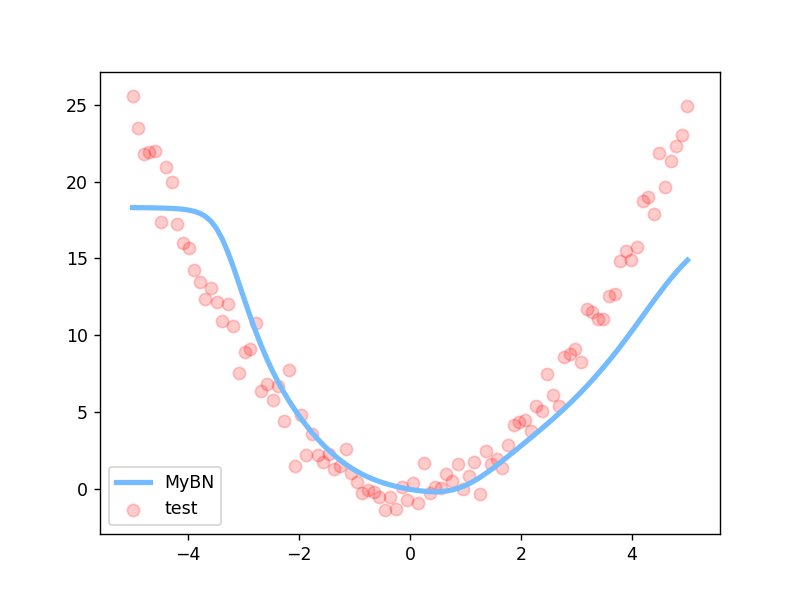

In [9]:
if __name__ == "__main__":
    l=[]                                  #loss
    for epoch in range(10):
        print('Epoch: ', epoch)
        net.eval()                       #测试模式    
        pred= net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        net.train()                      #训练模式
        
        for step, (b_x, b_y) in enumerate(train_loader):
            pred= net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
   
    print(l)             #输出Loss

    #可视化loss
    plt.figure(1)
    plt.plot(l, c='#74BCFF', lw=2, label='loss_MyBN')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 200));plt.legend(loc='best')

    #测试，并且将拟合曲线展示出来
    net.eval() 
    preds = net(test_x)
    plt.figure(2)
    plt.plot(test_x.data.numpy(), preds.data.numpy(), c='#74BCFF', lw=3, label='MyBN')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='test')
    plt.legend(loc='best')
    plt.show()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
[127.47228240966797, 95.59752655029297, 53.63540267944336, 29.7847843170166, 20.183799743652344, 9.571290969848633, 8.90230941772461, 6.784908771514893, 9.042152404785156, 20.811538696289062]


<IPython.core.display.Javascript object>


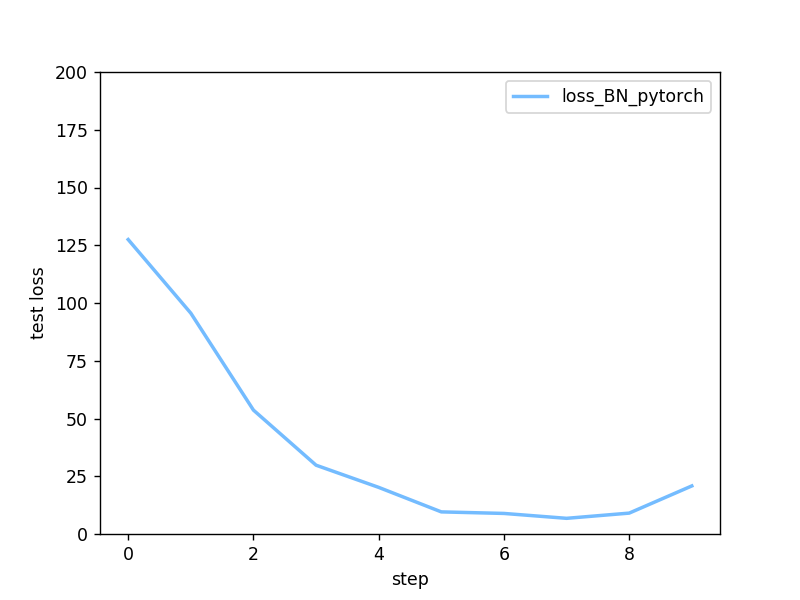

<IPython.core.display.Javascript object>


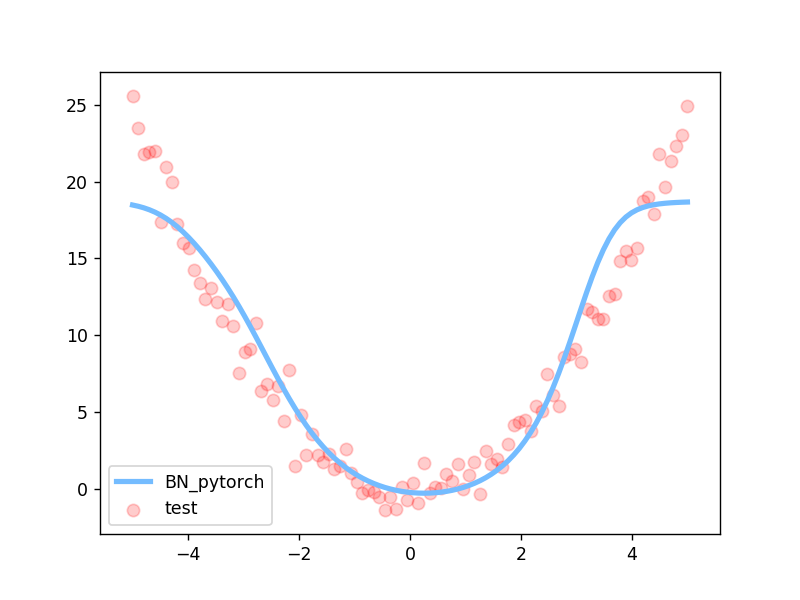

In [10]:
#使用pytorch提供的BN层，搭建结构和之前类似的网络模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #self.bn_input=nn.BatchNorm1d(1,momentum=0.5)
        self.fc0=nn.Linear(1,10)
        self.bn0=nn.BatchNorm1d(10,momentum=0.5)
        self.fc1=nn.Linear(10,10)
        self.bn1=nn.BatchNorm1d(10,momentum=0.5)
        self.fc2=nn.Linear(10,10)
        self.bn2=nn.BatchNorm1d(10,momentum=0.5)
        self.fc3=nn.Linear(10,10)
        self.bn3=nn.BatchNorm1d(10,momentum=0.5)
        self.predict=nn.Linear(10,1)
    
    def forward(self,x):
        x = self.fc0(x)
        x = self.bn0(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc1(x)
        x = self.bn1(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc2(x)
        x = self.bn2(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc3(x)
        x = self.bn3(x)   # batch normalization
        x = torch.tanh(x)

        out=self.predict(x)
        return out

net=Net() 
opt=torch.optim.Adam(net.parameters(),lr=0.02)
#print(opt.param_groups) 

loss_func=nn.MSELoss()
if __name__ == "__main__":
    l=[] 
    for epoch in range(10):
        print('Epoch: ', epoch)
        net.eval()              # set eval mode to fix moving_mean and moving_var
        pred = net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        net.train()             # free moving_mean and moving_var
        for step, (b_x, b_y) in enumerate(train_loader):
            pred = net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
    print(l)
    plt.figure(1)
    
    plt.plot(l, c='#74BCFF', lw=2, label='loss_BN_pytorch')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 200));plt.legend(loc='best')

    # evaluation
    # set net to eval mode to freeze the parameters in batch normalization layers
    net.eval() 
    preds = net(test_x)
    plt.figure(2)

    plt.plot(test_x.data.numpy(), preds.data.numpy(), c='#74BCFF', lw=3, label='BN_pytorch')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='test')
    plt.legend(loc='best')
    plt.show()


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
[130.5618438720703, 80.26296997070312, 60.350833892822266, 58.7513313293457, 58.7475700378418, 58.639400482177734, 58.6114501953125, 58.61245346069336, 58.609703063964844, 58.6277961730957]


<IPython.core.display.Javascript object>


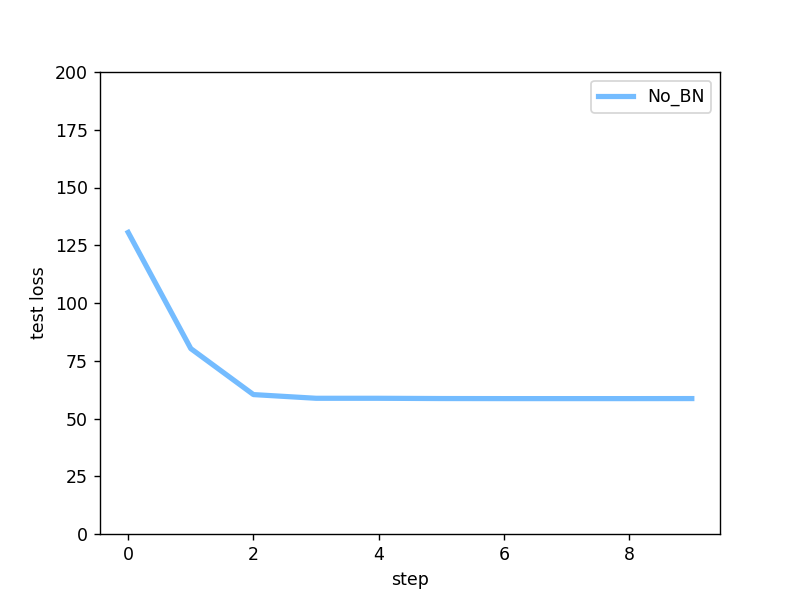

<IPython.core.display.Javascript object>


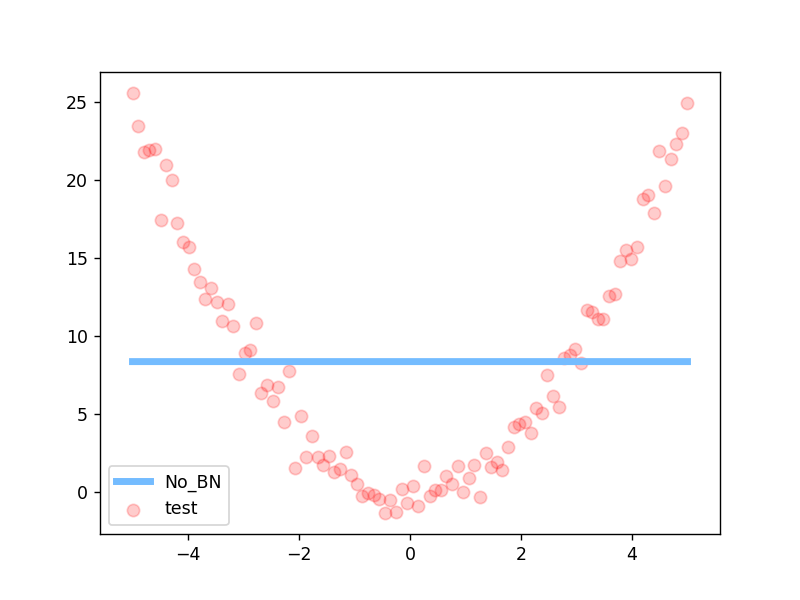

In [11]:
#将BN层去除，看在不经过Batch Normlization，神经网络会怎么样
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.fc0=nn.Linear(1,10)
        self.fc1=nn.Linear(10,10)
        self.fc2=nn.Linear(10,10)
        self.fc3=nn.Linear(10,10)
        self.predict=nn.Linear(10,1)
    
    def forward(self,x):

        x = self.fc0(x)
        x = torch.tanh(x)
 
        x = self.fc1(x)
        x = torch.tanh(x)

        x = self.fc2(x)
        x = torch.tanh(x)

        x = self.fc3(x)
        x = torch.tanh(x)

        out=self.predict(x)
        return out


net=Net() 
opt=torch.optim.Adam(net.parameters(),lr=0.02)
loss_func=nn.MSELoss()
if __name__ == "__main__":
    l=[] 
    for epoch in range(10):
        print('Epoch: ', epoch)
        net.eval()              # set eval mode to fix moving_mean and moving_var
        pred= net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        net.train()             # free moving_mean and moving_var
        for step, (b_x, b_y) in enumerate(train_loader):
            pred = net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
    print(l)
    plt.figure(1)
    
    plt.plot(l, c='#74BCFF', lw=3, label='No_BN')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 200));plt.legend(loc='best')


    net.eval() 
    preds = net(test_x)
    plt.figure(2)
    plt.plot(test_x.data.numpy(), preds.data.numpy(), c='#74BCFF', lw=4, label='No_BN')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='test')
    plt.legend(loc='best')
    plt.show()
    
    
#从下图可以看出，当输入数据在（-5,5）区间时，由于大量数据分布在激活函数的梯度饱和区，
#如果不经过batch normalization的处理，神经网络会失去学习能力


In [ ]:
'''
实验过程中遇到的问题：
1、我初始的想法是，对于BN层的forward和backward都由自己编写，在反向传播时，利用dL/dy以及正向过程中存储的变量求出dL/dγ、dL/dβ、dL/dx，但
是由于要利用后层的梯度，并且对前层参数的更新有影响，而在pytorch搭建的网络里，其它层反向传播更新参数的过程都是自动完成的，所以一开始在bn层
参数的更新上遇到了麻烦；
   后来经过查资料，可以把自定义BN层的参数放入网络的param_groups中，由pytorch来对我需要更新的参数进行更新，所有只需要编写forward部分即可；
   
2、由于训练模型时是基于minibatch的，而测试的时候无需分批，所以要区分这两个过程，参考了网上的资料，用两个参数moving_mean和moving_var来记录
全局的均值和方差。

'''